# Tópicos selectos de análisis de datos
# Tarea 3
### Alumno: Marcelo Alberto Sanchez Zaragoza

| Descripción:                         | Fechas                  |
|--------------------------------------|-------------------------|
| Fecha de publicación del documento:  | **Septiembre 27, 2021** |
| Fecha límite de entrega de la tarea: | **Octubre 11, 2021**    |

## Instrucciones:

- Entrega un solo jupyter notebook por tarea. Incluye cualquier archivo, imagen, datos, etcétera, para que pueda ejecutarse. Si lo crees conveniente, puedes usar latex para los ejercicios que lo requieran.

- Usa python 3.x 

- Todos tus archivos DEBES nombrarlos con el siguiente formato: TareaXXX_Nombre_Apellido.ipynb, TareaXXX_Nombre_Apellido.pdf, TareaXXX_Nombre_Apellido.csv, etcétera.

- Crea una carpeta con nombre TareaXXX_Nombre_Apellido donde incluirás todos tus archivos, y entrega UN SOLO archivo ZIP usando el mismo formato para el nombre: TareaXXX_Nombre_Apellido.zip

- Manda las tareas con nuestros ayudantes: marco.perez@cimat.mx y javier.carrillo@cimat.mx (opcionalmente con copia a mi)

- LAS TAREAS SON INDIVIDUALES, a menos que se especifique lo contrario


---

## Ejercicio 1 (4 puntos)

Crear una red neuronal que clasifique los colores de los pixeles en una imagen en dos categorías: objeto o  fondo.

1. Use como base el script ``marcadoPixeles.py``, que se encuentra dentro del arcchivo ``datosTarea03Ejercicio1.zip``,
   para abrir una imagen y con el mouse marcar los pixeles 
   del fondo de la imagen y pixeles sobre el objeto. La salida de este script genera un archivo CSV 
   con los colores BGR de los pixeles marcados más una columna que indica la categoría (0 para fondo y 1 
   para el objeto). La idea es que con este script marque pixeles cuyos colores sean representativos del fondo y del
   objeto.
   Nota que se graban los colores como BGR y no RGB porque BGR es el formato predeterminado
   que usa OpenCV al leer una imagen. Puede cambiar el orden, pero hay que ser consistencia cuando se quiera
   usar la red neuronal.
   
   Modifique este script para que también se graben en el archivo CSV los colores de esos pixeles en el espacio HSV.
   Para cada una de las imágenes en el archivo ``datosTarea03Ejercicio1.zip`` cree el archivo CSV correspondiente
   de modo que el objeto sea una manzana.
2. Para cada archivo CSV:

- Divida los datos en un conjunto de entrenamiento y otro de prueba.
- Cree una red neuronal que tome como entrada los colores HSV del conjunto de entrenamiento.
- Reporte la exactitud que tiene el clasificador en el conjunto de entrenamiento y prueba.
- Lea la imagen correspondiente $I$ al archivo CSV y cree arreglo 2D $M_1$ lleno de ceros con el mismo 
  número de filas y columnas que la imagen.
- Recorra los pixeles de la imagen $I$, obtenga su color HSV y use la red neuronal para clasificarlo.
  Si se clasifica como "objeto", asignar el valor 255 en el pixel correspondiente en la imagen $M_1$
- Muestre la imagen $M_1$ obtenida. Esto debe verse como la máscara binaria de la manzana.
- Puede pasar que aparezcan otras regiones adicionales. Una manera de removerlas es obtener el contorno
  de la región más grande y usarlo para generar una máscara binaria que solo contenga ese contorno.
  El siguiente código hace esto. Muestre el resultado.

```
# Se determinan los contornos en la marcara M1. 
contours, hierarchy = cv2.findContours(M1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
ncontours = len(contours)
print('Numero de contornos:', ncontours)

# Se encuentra el índice imax del contorno más grande
imax = 0
dmax = 0
for i,cnt in enumerate(contours):
    if len(cnt)>dmax:
        dmax = len(cnt)
        imax = i

# Obtenemos el contorno más grande y se imprimen algunos datos
cnt  = contours[imax]
area = cv2.contourArea(cnt)
dlen = cv2.arcLength(cnt,False)
print("    Contorno %d: Longitud=%8.3f   Area=%8.3f  " % (imax, dlen, area))

# Creacion de la mascara binaria a partir de dibujar el contorno más grande
M2   = np.zeros(M1.shape, dtype=np.uint8)
cv2.drawContours(M2, [cnt], -1, 255, -1)

plt.imshow(M2, cmap='gray')
plt.title('Máscara binaria')
plt.show()
```

3. Repita el punto anterior usando ahora los colores BGR para crear al clasificador.
4. Escriba un comentario sobre los resultados obtenidos usando el espacio de color BGR 
   y el espacio de color HSV.

### Solución

### En la siguientes lineas de código se van a mostrar los resultados y cada uno de los puntos que pide el ejercicio 1.

In [2]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import os

Las siguiente función $contorno\_m$ nos ayuda a depurar el resultado de buscar la mascara binaria, nos ayuda a mejorar el resultado.

In [3]:
def contorno_m(mask_exp_1):
    contours, hierarchy = cv2.findContours(mask_exp_1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    ncontours = len(contours)
    #print('Numero de contornos:', ncontours)
    # Se encuentra el índice imax del contorno más grande
    imax = 0
    dmax = 0
    for i,cnt in enumerate(contours):
        if len(cnt)>dmax:
            dmax = len(cnt)
            imax = i
    # Obtenemos el contorno más grande y se imprimen algunos datos
    cnt = contours[imax]
    area = cv2.contourArea(cnt)
    dlen = cv2.arcLength(cnt,False)
    #print(" Contorno %d: Longitud=%8.3f Area=%8.3f " % (imax, dlen, area))
    # Creacion de la mascara binaria a partir de dibujar el contorno más grande
    M2 = np.zeros(mask_exp_1.shape, dtype=np.uint8)
    cv2.drawContours(M2, [cnt], -1, 255, -1)
    return M2

La siguiente función $Jordan$ nos ayuda a encontrar cada uno de los puntos que nos pide el ejercicio, en dichos resultados se muestra la presición de ocupar cualquiera de los dos canales(RGB ó HSV), la mascara binaria y regresando en una matriz llamada M2 dicha mascara binaria.

Hay una variable llamada canal, si proporcionamos el valor de 1 toma en cuenta el canal $HSV$ y en cualquier otro caso el canal $RGB$, es la unica variable que se agrego a las dos solicitadas anteriormente.

In [4]:
def Jordan(imagen, info, canal):
## En el siguiente if realiza una selección de los datos del archivo CSV ya que contiene datos en ambos canales, dependiendo
##  lo que se desea obtener proporciona los valores de un canal u otro.
    if(canal == 1):##HSV
        X = info.iloc[:,4:] #cargamos los valores del canal HSV
    else: ## RGB
        X = info.iloc[:,0:3] #cargamos los valores del canal HSV
    y = info.iloc[:,3] # cargamos las clases
## En las siguiente dos lineas definimos nuestros datos de entrenamiento y prueba para la red 
## Se realizo una selección de 80% de entrenamiento y 20% de prueba
    X_train, X_test = train_test_split(X, test_size=0.2, train_size=0.8, random_state=42)
    y_train, y_test = train_test_split(y, test_size=0.2, train_size=0.8, random_state=42)
################ Red neuronal que se implemento
## En la sifuiente lineas mostramos la estructura de los parametros que se emplearon en la red neuronal
    hls = [10,10] #[10,3]
    a = 0.5
    mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=hls,early_stopping = True, 
                    random_state=0, alpha=a, max_iter=1500).fit(X_train, y_train)
## Una vez entrendado el modelo realizamos la predicción para ambos conjuntos, el de entrenamiento y prueba.
    y_pred_1 = mlp.predict(X)
    y_pred_2 = mlp.predict(X_test)
############### Reportamos algunas metricas y el accuracy obtenido 
## Se imprimen en pantalla la exactitud del modelo tomando ambos conjuntos y algunas otras metricas
    print('Exactitud de la Red Neuronal con datos de entrenamiento')
    print(metrics.classification_report(y, y_pred_1))
    print('\n')
    print('Exactitud de la Red Neuronal con datos de prueba')
    print(metrics.classification_report(y_test, y_pred_2))
## Obtenemos las dimensiones de la imagen que posteriormente nos ayudaran a recorrer toda la imagen y obtener todo el conjunto
##  de pixeles que contiene y realizar la predicción 
    renglon, columna,_ = imagen.shape
    l_total=[]
## Hacemos dos casos si se escogio el canal HSV se realiza la visualización de la imagen en ese canal
    if(canal == 1):
        img2_HSV = cv2.cvtColor(imagen, cv2.COLOR_RGB2HSV) ### observe que se abrio en el canal HSV
    ## Comenzamos a recorrer la imagen para obtener los valores de cada uno de los pixeles en este canal
        for i in range(renglon):
            for j in range(columna):
                s = []
                for k in range(3):
                    aux = img2_HSV[i][j][k]
                    s.append(aux)
                l_total.append(s)
    ## Al final guardamos los valores en un dataframe, se hace eso ya que es más comodo para pasarlo al modelo de la red
    ##  neuronal
        tabla_final =pd.DataFrame(l_total)
        tabla_final.columns = ['H', 'S', 'V'] # definimos los nombres de las columnas 
    ## Realizamos la predicción de cada uno de los pixeles, donde nos regresa un vector con valores de cero y uno
    ##  donde el valor de uno nos indica presencia de objeto y cero el fondo.
        y_pred_3 = mlp.predict(l_total)
        tabla_final['clase_f'] = y_pred_3
        TR3 = []
        feo = columna*renglon ## Es indicador para realizar la iteraciones
        for i in range(feo):
            if(tabla_final.iloc[i,3] == 1): ## Condición para asignar el valor de 255 que nos pide la tarea
                TR3.append(255)
            else: ## En caso contrario se les da valor de cero
                TR3.append(0)
    ## Construimos nuestra matriz M1, en dicha matriz obtenemos los valores de 255 para pixeles del objeto y 0 para pixeles
    ##  correspondientes al fondo
        M1 = np.array(TR3).reshape(renglon,columna) 
    else:
## Segundo caso, el caso donde nos proporcionan el espacio BGR 
        img2_RGB = imagen ## La imagen la mantenemos igual, no realiza ningun cambio 
    ## En las siguientes lineas el proceso es igual al anterior, la unica diferencia fue el cambio de canal
        for i in range(renglon):
            for j in range(columna):
                s = []
                for k in range(3):
                    aux = img2_RGB[i][j][k]
                    s.append(aux)
                l_total.append(s)
        tabla_final =pd.DataFrame(l_total)
        tabla_final.columns = ['R', 'G', 'B']
        y_pred_3 = mlp.predict(l_total)
        tabla_final['clase_f'] = y_pred_3
        TR3 = []
        feo = columna*renglon
        for i in range(feo):
            if(tabla_final.iloc[i,3] == 1):
                #TR3.append([255,255,255])
                TR3.append(255)
            else:
                #TR3.append([0,0,0])
                TR3.append(0)
    ### volvemos a obtener la matriz M1, en este caso proporcionamos las dimensiones que debe tener
        M1 = np.array(TR3).reshape(renglon,columna)
### En las siguientes dos lineas de código, se realiza una depuración de la primer matriz M1, ya que hubo casos donde había
###  zonas donde marcaba pixeles de otro color y no queriamos eso 
    M1 = np.array(M1,dtype=np.uint8)    
    M2 = contorno_m(M1)
### Finalmente mostramos el resultado de dicha depuración y regresamos dicha matriz.
    plt.imshow(M2, cmap='gray')
    plt.title('Máscara binaria')
    plt.show()
    return M2 

Lo que se va a mostrar a continuación es el resultado de aplicar la función a cada imagen en ambos canales.

In [5]:
os.getcwd()

'C:\\Users\\Marcelo Sanchez\\OneDrive\\Escritorio\\Tercer Semestre CIMAT\\Temas Ciencia de Datos II\\Tareas\\Tarea_3\\Imagenes\\Ejercicio-2'

#### Encontramos el filtro para la imagen 1

In [6]:
myDir   = 'C:\\Users\\Marcelo Sanchez\\OneDrive\\Escritorio\\Tercer Semestre CIMAT\\Temas Ciencia de Datos II\\Tareas\\Tarea_3\\Imagenes\\Ejercicio-2\\'
img_1 = cv2.imread(myDir + 'redDelicious001.jpg')

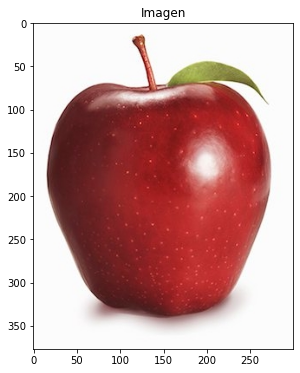

In [7]:
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_1[:,:,::-1])
plt.title('Imagen')
plt.show()

In [8]:
info = pd.read_csv('prueba1hsv.csv',encoding='latin1')
info.columns = ['B', 'G', 'R', 'clase', 'H', 'S','V']
info

,B,G,R,clase,H,S,V
0,252,252,252,0,0.0,0.0,252.0
1,252,252,252,0,0.0,0.0,252.0
2,252,252,252,0,0.0,0.0,252.0
3,252,252,252,0,0.0,0.0,252.0
4,252,252,252,0,0.0,0.0,252.0
...,...,...,...,...,...,...,...
4793,29,29,153,1,120.0,207.0,153.0
4794,29,29,153,1,120.0,207.0,153.0
4795,31,27,152,1,121.0,210.0,152.0
4796,28,25,148,1,121.0,212.0,148.0


Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1746
           1       1.00      1.00      1.00      3052

    accuracy                           1.00      4798
   macro avg       1.00      1.00      1.00      4798
weighted avg       1.00      1.00      1.00      4798



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       601

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



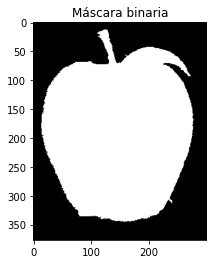

In [61]:
############# Espacio HSV 
r1 = Jordan(img_1, info, 1)

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1746
           1       1.00      0.99      1.00      3052

    accuracy                           0.99      4798
   macro avg       0.99      0.99      0.99      4798
weighted avg       0.99      0.99      0.99      4798



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       359
           1       1.00      0.99      0.99       601

    accuracy                           0.99       960
   macro avg       0.99      0.99      0.99       960
weighted avg       0.99      0.99      0.99       960



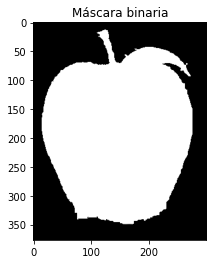

In [62]:
############# Espacio RGB 
r12 = Jordan(img_1, info, 2)

#### Encontramos el filtro para la imagen 2

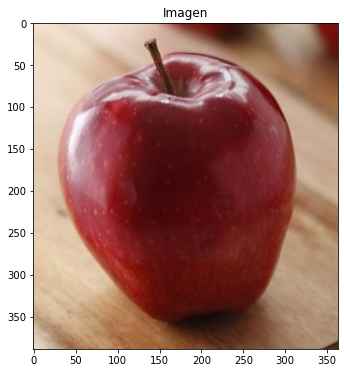

In [63]:
img_1 = cv2.imread(myDir + 'redDelicious002.jpg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_1[:,:,::-1])
plt.title('Imagen')
plt.show()

In [64]:
info = pd.read_csv('prueba2hsv.csv',encoding='latin1')
info.columns = ['B', 'G', 'R', 'clase', 'H', 'S','V']
info

,B,G,R,clase,H,S,V
0,207,227,245,0,104,40,245
1,208,228,246,0,104,39,246
2,207,227,245,0,104,40,245
3,204,226,244,0,104,42,244
4,205,227,245,0,104,42,245
...,...,...,...,...,...,...,...
6231,13,8,69,1,122,225,69
6232,13,8,69,1,122,225,69
6233,13,9,68,1,122,221,68
6234,12,8,67,1,122,225,67


Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3168
           1       0.97      0.97      0.97      3068

    accuracy                           0.97      6236
   macro avg       0.97      0.97      0.97      6236
weighted avg       0.97      0.97      0.97      6236



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       647
           1       0.98      0.98      0.98       601

    accuracy                           0.98      1248
   macro avg       0.98      0.98      0.98      1248
weighted avg       0.98      0.98      0.98      1248



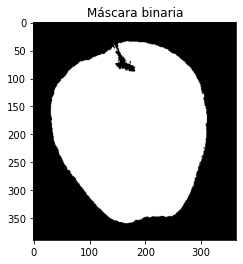

In [65]:
############# Espacio HSV 
r2 = Jordan(img_1, info, 1)

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3168
           1       0.96      0.98      0.97      3068

    accuracy                           0.97      6236
   macro avg       0.97      0.97      0.97      6236
weighted avg       0.97      0.97      0.97      6236



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       647
           1       0.97      0.98      0.98       601

    accuracy                           0.98      1248
   macro avg       0.98      0.98      0.98      1248
weighted avg       0.98      0.98      0.98      1248



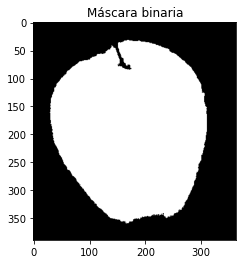

In [66]:
############# Espacio RGB 
r22 = Jordan(img_1, info, 2)

#### Encontramos el filtro para la imagen 3

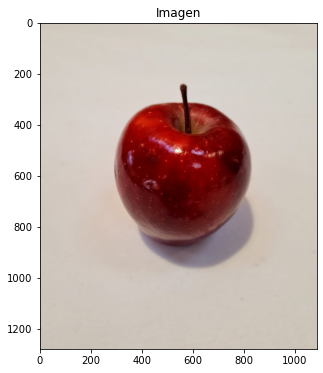

In [75]:
img_1 = cv2.imread(myDir + 'figura_3.jpeg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_1[:,:,::-1])
plt.title('Imagen')
plt.show()

In [76]:
info = pd.read_csv('exp_3.csv',encoding='latin1')
info.columns = ['B', 'G', 'R', 'clase', 'H', 'S','V']
info

,B,G,R,clase,H,S,V
0,188,199,207,0,103,23,207
1,188,199,207,0,103,23,207
2,186,199,207,0,101,26,207
3,186,199,207,0,101,26,207
4,186,199,207,0,101,26,207
...,...,...,...,...,...,...,...
14710,1,1,139,1,120,253,139
14711,3,3,141,1,120,250,141
14712,2,2,140,1,120,251,140
14713,1,0,140,1,120,255,140


Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7741
           1       1.00      1.00      1.00      6974

    accuracy                           1.00     14715
   macro avg       1.00      1.00      1.00     14715
weighted avg       1.00      1.00      1.00     14715



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1575
           1       1.00      1.00      1.00      1368

    accuracy                           1.00      2943
   macro avg       1.00      1.00      1.00      2943
weighted avg       1.00      1.00      1.00      2943



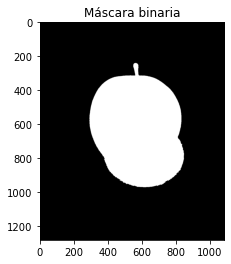

In [77]:
############# Espacio HSV 
r2 = Jordan(img_1, info, 1)

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7741
           1       1.00      0.99      0.99      6974

    accuracy                           0.99     14715
   macro avg       0.99      0.99      0.99     14715
weighted avg       0.99      0.99      0.99     14715



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1575
           1       1.00      0.99      0.99      1368

    accuracy                           0.99      2943
   macro avg       0.99      0.99      0.99      2943
weighted avg       0.99      0.99      0.99      2943



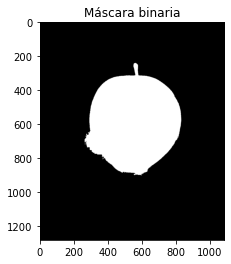

In [78]:
############# Espacio RGB 
r22 = Jordan(img_1, info, 2)

#### Encontramos el filtro para la imagen 4

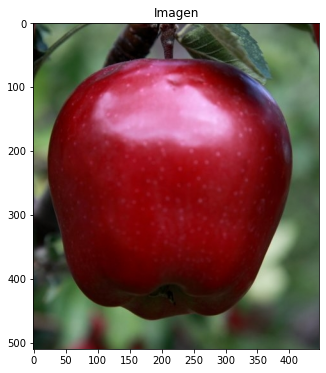

In [67]:
img_1 = cv2.imread(myDir + 'redDelicious004.jpg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_1[:,:,::-1])
plt.title('Imagen')
plt.show()

In [68]:
info = pd.read_csv('prueba4hsv.csv',encoding='latin1')
info.columns = ['B', 'G', 'R', 'clase', 'H', 'S','V']
info

,B,G,R,clase,H,S,V
0,63,75,53,0,46,75,75
1,59,72,48,0,46,85,72
2,57,70,46,0,46,87,70
3,54,67,43,0,46,91,67
4,47,60,36,0,46,102,60
...,...,...,...,...,...,...,...
11557,17,8,142,1,122,241,142
11558,17,7,143,1,122,243,143
11559,16,6,142,1,122,244,142
11560,17,8,142,1,122,241,142


Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5274
           1       0.97      0.97      0.97      6288

    accuracy                           0.97     11562
   macro avg       0.97      0.97      0.97     11562
weighted avg       0.97      0.97      0.97     11562



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1096
           1       0.97      0.96      0.96      1217

    accuracy                           0.96      2313
   macro avg       0.96      0.96      0.96      2313
weighted avg       0.96      0.96      0.96      2313



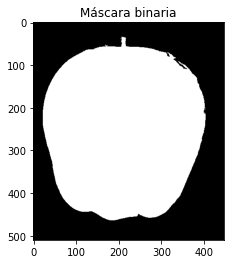

In [69]:
############# Espacio HSV 
r4 = Jordan(img_1, info, 1)

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5274
           1       0.98      0.97      0.97      6288

    accuracy                           0.97     11562
   macro avg       0.97      0.97      0.97     11562
weighted avg       0.97      0.97      0.97     11562



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1096
           1       0.98      0.97      0.97      1217

    accuracy                           0.97      2313
   macro avg       0.97      0.97      0.97      2313
weighted avg       0.97      0.97      0.97      2313



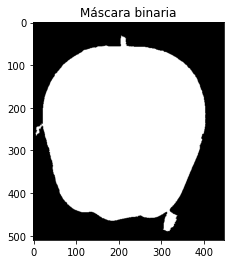

In [70]:
############# Espacio RGB 
r42 = Jordan(img_1, info, 2)

#### Comentarios:

La máscara binaria se solicito para ambos canales que nos pide el ejercicio, en ambos canales hay resultados buenos y otros no
tan buenos, además mostramos las metricas que se emplearon y su exactitud de acuerdo al accuracy. A continuación hablaremos de cada una de las imagenes y sus resultados.

$Imagen~1$

Los resultados fueron bastante buenos en ambos canales, podemos decir que el canal $HSV$ fue ligeramente mejor que el $BGR$ ya que en la parte del contorno el canal $BGR$ mostro ligeros bordes chuecos y el $HSV$ no mostro lo mismo. En ambos casos se encontro el objeto, es decir, se encontro la manzana, la hoja y la hoja verde, puede que nos ayudara mucho el hecho que el fondo era color blanco ya que observando los colores no hay mucho parecido pero incluso dentro de la manzana se observa un color blanco resultado del reflejo de alguna luz pero afortunadamente lo tomo como parte del objeto.

$Imagen~2$

En ambos canales el resultado fue muy similar, en ambos casos encontramos lugares donde no se observo que reconociera el palito de la manzana, una posible causa sea que el fondo coincide con el color del palito, esto puede ser una buena razón ya que en este caso cambio el color del fondo y no como en la primer imagen. Una posible solución podría ser volver a realizar la selección de los pixeles y ser más minucioso al seleccionar los correspondientes al palito.

$Imagen~3$

En la imagen número 3 se tuvieron problemas al intentar la selección de los pixeles ya que las dimensiones sobrepasaban el tamaño que nos proporciona la computadora para visualizar la ventana de selección de pixeles, se redujo las dimensiones pero no fue lo suficiente para observarla completamente. Se tomo la decisión de trabajar con la imagen hasta donde se pudiera seleccionar los pixeles y observar el resultado de dicha selección. Los resultados fueron muy distintos para ambos canales, en el canal $HSV$ cometio más errores en la selección de los pixeles ya que tomo unos que corresponden a la sombra de la fruta y el resultado no tiene la forma de la fruta. En el canal $RGB$ el resultado fue bastante bueno ya que logra rescatar en su gran mayoria los pixeles de la fruta pero agrega algunos pixeles correspondientes al fondo. Cabe recalcar que los resultados fueron buenos a pesar de no poder proporcionar más pixeles de la parte inferior de la imagen y esto puede ser el porque de que nuestros filtros tengan regiones adicionales a la que realmente buscamos. La imagen del resultado de la selección se anexa junto con este Jupyter Notebook.

$Imagen~4$

Las máscara en el canal $HSV$ nos dio un buen resultado, en dicha imagen se encontro bien el objeto, el objeto que se considero fue la manzana y el palito, la hoja se tomo como parte del fondo pero se puede tomar en cuenta si se desea y  posteriormente volver a correr dicho código. La máscara mostro algunas parte faltantes, son minimas pero nos da indicios que posiblemente hay que ser más minucioso al momento de seleccionar los pixeles. 
En el espacio $BGR$ encontramos algo curioso, tiene agregadas regiones que no forman parte del objeto, en la parte inferior tienen agregado una región con forma de triangulo, al observa la imagen original encontramos que esa parte es de color rojo y muy probablemente se confudiera y lo tomara como parte del objeto, esto debido solo a la coincidencia del color rojo. 


Luego de comentar los resultados de cada imagen hablaremos de forma general de ambos canales, los resultados de las metricas nos dicen que al entrenar el modelo con el canal $HSV$ son mejores para el grupo de entrenamiento y prueba, miestras que para el canal $BGR$ no es tan malo ya que nos da resultados cerca de 0.98 y 0.99 en el accuracy pero se encuentra por debajo. Cabe mencionar que para todas las imagenes no se cambio los parámetros del modelo y puede que esto sea un factor importante al momento de encontrar la mascara binaria, esto puede justificarse con el cambio en el fondo de la imagen, ya que en algunos casos son color blanco y en otros son colores parecidos al objeto. 
El resultado de la selección de pixeles y archivos.csv se anexaran junto con este Jupyter Noteboook como evidencia al igual que el archivo que solicito la tarea modificar para agregar el espacio $HSV$ al archivo.csv.


#### Extra
#### Imagen 2

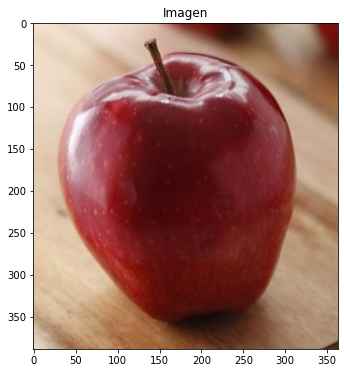

In [10]:
img_2 = cv2.imread(myDir + 'redDelicious002.jpg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_2[:,:,::-1])
plt.title('Imagen')
plt.show()

In [11]:
info = pd.read_csv('extra2.csv',encoding='latin1')
info.columns = ['B', 'G', 'R', 'clase', 'H', 'S','V']
info

,B,G,R,clase,H,S,V
0,205,227,245,0,104,42,245
1,203,225,243,0,104,42,243
2,202,224,242,0,104,42,242
3,201,223,241,0,104,42,241
4,201,223,241,0,104,42,241
...,...,...,...,...,...,...,...
4425,34,42,131,1,118,189,131
4426,35,43,133,1,118,188,133
4427,39,47,136,1,118,182,136
4428,41,51,138,1,117,179,138


Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1983
           1       0.98      0.97      0.97      2447

    accuracy                           0.97      4430
   macro avg       0.97      0.97      0.97      4430
weighted avg       0.97      0.97      0.97      4430



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       418
           1       0.97      0.98      0.97       468

    accuracy                           0.97       886
   macro avg       0.97      0.97      0.97       886
weighted avg       0.97      0.97      0.97       886



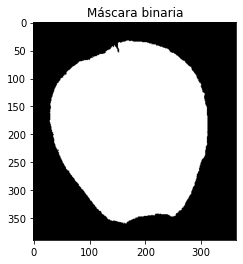

In [12]:
############# Espacio HSV 
rextra2 = Jordan(img_2, info, 1)

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1983
           1       0.97      0.97      0.97      2447

    accuracy                           0.97      4430
   macro avg       0.97      0.97      0.97      4430
weighted avg       0.97      0.97      0.97      4430



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       418
           1       0.96      0.98      0.97       468

    accuracy                           0.97       886
   macro avg       0.97      0.97      0.97       886
weighted avg       0.97      0.97      0.97       886



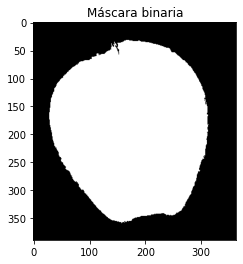

In [13]:
############# Espacio RGB 
rextra22 = Jordan(img_2, info, 2)

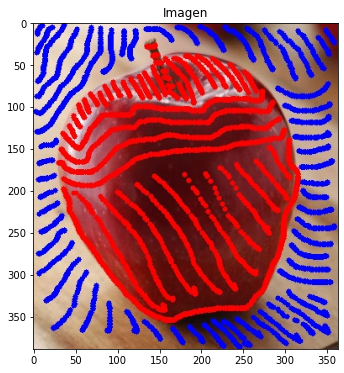

In [17]:
img_2 = cv2.imread(myDir + 'extra2.jpg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_2[:,:,::-1])
plt.title('Imagen')
plt.show()

Se volvio a analizar el resultado de la imagen 2, se intento ser más minucioso al intentar seleccionar los pixeles pero no se logro identidicar el palito de la manzana, incluso el filtro pareciera que lo corta. El resultado en ambos canales fue bastante bueno comparado con el visto anteriormente.

#### Imagen 4

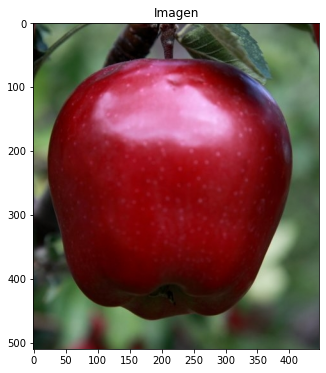

In [18]:
img_1 = cv2.imread(myDir + 'redDelicious004.jpg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_1[:,:,::-1])
plt.title('Imagen')
plt.show()

In [20]:
info = pd.read_csv('extra.csv',encoding='latin1')
info.columns = ['B', 'G', 'R', 'clase', 'H', 'S','V']
info

,B,G,R,clase,H,S,V
0,114,103,106,0,172,25,114
1,112,101,104,0,172,25,112
2,114,103,106,0,172,25,114
3,115,103,109,0,165,27,115
4,117,103,109,0,167,31,117
...,...,...,...,...,...,...,...
10521,5,4,90,1,120,244,90
10522,4,4,88,1,120,243,88
10523,5,4,90,1,120,244,90
10524,5,5,89,1,120,241,89


Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      3719
           1       0.95      0.87      0.91      6807

    accuracy                           0.89     10526
   macro avg       0.87      0.89      0.88     10526
weighted avg       0.89      0.89      0.89     10526



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       756
           1       0.95      0.86      0.90      1350

    accuracy                           0.88      2106
   macro avg       0.87      0.89      0.87      2106
weighted avg       0.89      0.88      0.88      2106



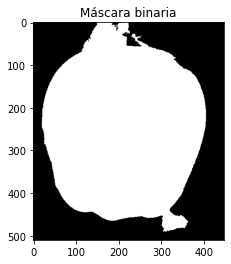

In [21]:
############# Espacio HSV 
r4 = Jordan(img_1, info, 1)

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3719
           1       0.92      0.86      0.89      6807

    accuracy                           0.87     10526
   macro avg       0.85      0.87      0.86     10526
weighted avg       0.87      0.87      0.87     10526



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       756
           1       0.92      0.85      0.89      1350

    accuracy                           0.86      2106
   macro avg       0.84      0.86      0.85      2106
weighted avg       0.87      0.86      0.86      2106



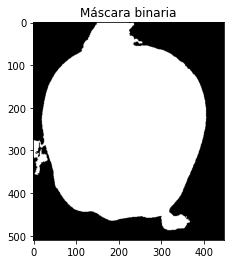

In [22]:
############# Espacio RGB 
r42 = Jordan(img_1, info, 2)

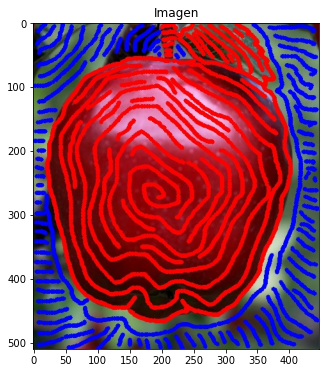

In [23]:
img_2 = cv2.imread(myDir + 'extra4.jpg')
fig, ax    = plt.subplots(figsize=(11, 6))
ax.imshow(img_2[:,:,::-1])
plt.title('Imagen')
plt.show()

Finalmente en la imagen 4 se tomo en cuenta la hoja como parte de la fruta, se muestra la imagen con la selección de pixeles, se hubiera esperado que lo identificara pero no fue el caso ya que tomo encuenta ciertas zonas que no corresponde a la misma, incluso nuestra una máscara en ambos canales peor que en las anteriores. 

## Ejercicio 2 (6 puntos)

Crear una red neuronal que reciba como entrada un vector de características de una imagen de un vegetal
y devuelva su categoría.

Se van a usar las imágenes que se encuentran en los archivos  ``datosTarea03Ejercicio2_train.zip``
y  ``datosTarea03Ejercicio2_test.zip``.
La liga para descargar los datos de este ejercicio se proporcionará el martes 28
de septiembre.

En estas carpetas sólo están las imágenes a color. En los algoritmos de extracción de características
se puede requerir la máscara binaria del objeto. Para las imágenes proporcionadas el fondo es de color
blanco, por lo que la siguiente función puede calcular y devolver la máscara binaria de una de estas
imágenes de color.

In [1]:
def calcularMascara(img):
    h,w,_ = img.shape
    # Arreglos para las mascaras binarios de los canales rojos, verde y azul
    Mr = np.zeros((h,w), dtype=np.uint8)
    Mg = np.zeros((h,w), dtype=np.uint8)
    Mb = np.zeros((h,w), dtype=np.uint8)
    Mb[img[:,:,0]<252] = 255
    Mg[img[:,:,1]<252] = 255
    Mr[img[:,:,2]<252] = 255
    # La mascara definida por el color blanco debe ser el producto de las mascaras anteriores
    M1 = Mr * Mb * Mg
    
    # Como puede haber tonos blancos sobre el objeto, hay que hacer una correccion:
    # Se determinan los contornos en la marcara M1. 
    contours, hierarchy = cv2.findContours(M1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    ncontours = len(contours)

    # Se encuentra el índice imax del contorno más grande
    imax = 0
    dmax = 0
    for i,cnt in enumerate(contours):
        if len(cnt)>dmax:
            dmax = len(cnt)
            imax = i

    # Obtenemos el contorno más grande y se imprimen algunos datos
    cnt  = contours[imax]

    # Creacion de la mascara binaria a partir de dibujar el contorno más grande
    M2   = np.zeros(M1.shape, dtype=np.uint8)
    cv2.drawContours(M2, [cnt], -1, 255, -1)
    return M2


1. Programe una función que reciba como entrada una imagen y la máscara binaria del objeto, 
   obtenga un vector de características relacionadas con color, forma y textura, 
   y devuelva este vector.
   
   Puede usar como referencia los notebooks vistos en clases para programar diferentes
   funciones que extraigan las características y la función que se pide  haga la concatenación
   de estas características. Documente las funciones que programe indicando cual es la 
   característica que está calculando.
   
   Por ejemplo, puede generar un histograma de alguna característica y devolver algunos 
   estadísticos o cuantiles para resumir ese histograma. 
2. Usando las imágenes del archivo ``datosTarea03Ejercicio2_train.zip`` cree un archivo 
   CSV que tenga en cada fila el vector de características asociada a cada imagen y
   una etiqueta que indique la clase a la que pertenece. Estos datos son para el conjunto
   de entrenamiento del clasificador.
3. Repita lo anterior con las imágenes del archivo ``datosTarea03Ejercicio2_test.zip`` para
   crear el archivo CSV con las características usadas para formar el conjunto de prueba.   
4. Con los datos anteriores cree una red neuronal multiclase. Use la estrategia early stopping 
   para evitar el sobreajuste de la red. Genere la matriz de confusión
   de los resultados del clasificador con ese conjunto de prueba. Agregue un comentario 
   sobre si en las clases en donde más errores hay es porque tienen características similares
   y si esto da un indicio sobre que tipo de características se tendrían que agregar o mejorar
   para reducir los errores de clasificación.

### Solución:

### En la siguientes lineas de código se van a mostrar los resultados y cada uno de los puntos que pide el ejercicio 2.

In [2]:
# Se cargan las distintas librerias que se ocuparon en las siguientes lineas de código.
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from scipy import signal
from os.path import isfile, join
import numpy as np
import pandas as pd
import csv
from skimage import color
import cv2
import os

En la siguiente linea se implemento 3 funciones, todas ellas fueron proporcionada por el profesor, solo fue necesario convertirlas a función. La primer función $calcularMascara$ nos ayuda a encontar la mascara binaria que posteriormente nos ayudara, la función $gabor$ nos ayuda a encontrar distintos filtros de gabor proporcionado distintos parámetros y la última función $contorno\_m$ nos ayuda a depurar la mascara binaria ya que en ocasiones tenemos ligeros puntos que nos estorban, la función nos ayuda a corregir estas situaciones.

In [3]:
### Funcion para la mascara 
def calcularMascara(img):
    h,w,_ = img.shape
    # Arreglos para las mascaras binarios de los canales rojos, verde y azul
    Mr = np.zeros((h,w), dtype=np.uint8)
    Mg = np.zeros((h,w), dtype=np.uint8)
    Mb = np.zeros((h,w), dtype=np.uint8)
    Mb[img[:,:,0]<252] = 255
    Mg[img[:,:,1]<252] = 255
    Mr[img[:,:,2]<252] = 255
    # La mascara definida por el color blanco debe ser el producto de las mascaras anteriores
    M1 = Mr * Mb * Mg
    # Como puede haber tonos blancos sobre el objeto, hay que hacer una correccion:
    # Se determinan los contornos en la marcara M1.
    contours, hierarchy = cv2.findContours(M1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    ncontours = len(contours)
    # Se encuentra el índice imax del contorno más grande
    imax = 0
    dmax = 0
    for i,cnt in enumerate(contours):
        if len(cnt)>dmax:
            dmax = len(cnt)
            imax = i
    # Obtenemos el contorno más grande y se imprimen algunos datos
    cnt = contours[imax]
    # Creacion de la mascara binaria a partir de dibujar el contorno más grande
    M2 = np.zeros(M1.shape, dtype=np.uint8)
    cv2.drawContours(M2, [cnt], -1, 255, -1)
    return M1

def gabor(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma)/gamma

    nstds = 3   # A mas de nstds*sigma se desprecian los valores
    cth   = np.cos(theta)
    sth   = np.sin(theta)
    xmax = max(abs(nstds*sigma_x*cth), abs(nstds*sigma_y*sth))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds*sigma_x*sth), abs(nstds*sigma_y*cth))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), \
np.arange(xmin, xmax + 1))

    x_th =  x*cth + y*sth   # Rotacion de las variables
    y_th = -x*sth + y*cth

    gb = np.exp(-.5*(x_th**2/sigma_x**2 + y_th**2/sigma_y**2)) * \
np.cos(2*np.pi/Lambda*x_th + psi)
    return gb

def contorno_m(mask_exp_1):
    contours, hierarchy = cv2.findContours(mask_exp_1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    ncontours = len(contours)
    #print('Numero de contornos:', ncontours)
    # Se encuentra el índice imax del contorno más grande
    imax = 0
    dmax = 0
    for i,cnt in enumerate(contours):
        if len(cnt)>dmax:
            dmax = len(cnt)
            imax = i
    # Obtenemos el contorno más grande y se imprimen algunos datos
    cnt = contours[imax]
    area = cv2.contourArea(cnt)
    dlen = cv2.arcLength(cnt,False)
    #print(" Contorno %d: Longitud=%8.3f Area=%8.3f " % (imax, dlen, area))
    # Creacion de la mascara binaria a partir de dibujar el contorno más grande
    M2 = np.zeros(mask_exp_1.shape, dtype=np.uint8)
    cv2.drawContours(M2, [cnt], -1, 255, -1)
    return M2

En la siguiente linea realizamos la función que nos pide el ejercicio, en este caso la función se llama $Kobe$, dicha función recibe como argumentos una imagen y su mascara binaria, al recibir dicha imagen la función realiza lo siguiente:

1.- Dada la mascara binaria realiza la depuración de la misma, es decir, encuentra el contorno de mayor tamaño y con eso trabaja.

2.- Trabaja la imagen en dos canales de colores, el RGB y HSV, ya que tiene dichos valores encontra los pixeles correpondientes a la mascara binaria y estos mismos los encuentra en cada una de las imagenes en RGB y HSV.

3.- Encuentra en cada canal la media, el minimo en el canal RGB y los cuantiles respecto al 0.75, la variable la que nos ayuda a realiza dicho calculo es la misma que nos ayuda a realizar el histograma si fuera el caso.

4.- Encontramos los momentos de la imagen apoyandonos de la mascara binaria.

5.- Proporcionamos varios parámetros para hacer un conjunto de filtros de Gabor, dicha familia nos ayudara a encontrar distintas caracteristicas de cada una de las imagenes, al final guardamos los cuantiles correspondientes al 0.5 y 0.75, la media, el máximo y mínimo del ultimo filtro de Gabor.

6.- La función regresa una lista con todas caracteristicas, se tiene un total de 22 valores guardados.

In [4]:
def Kobe(exp_1, mask_1):
    mask_exp_1 = contorno_m(mask_1)# depuramos ciertas parte de la imagen que no nos ayudan mucho
    l = [] # lista que va a guadar todas la caracteristicas
################################################# COLOR ##################################################################
    ### espacio rgb
    rgbimg1 = cv2.cvtColor(exp_1, cv2.COLOR_BGR2RGB)
    ### espacio hsv
    hsvimg1 = cv2.cvtColor(exp_1, cv2.COLOR_BGR2HSV)
    # Obtenemos la lista de las coordenadas de los pixeles que son blancos en la mascara binaria
    coords1 = np.column_stack(np.where(mask_exp_1 > 0))
    # Obtenemos la lista de colores RGB del objeto
    rgb1    = rgbimg1[coords1[:,0], coords1[:,1],:]
    # Generamos el arreglo que tiene los colores HSV de los pixeles sobre el objeto 
    hsv1 = hsvimg1[coords1[:,0], coords1[:,1],:]
    # comenzamos a guardar los primeros valores
    p = cv2.mean(rgb1)
    q = cv2.mean(hsv1)
    l.append( rgb1.min() )
    l.append( p[0] )
    #l.append( hsv1.max() )
    l.append( q[0] )
    l.append(np.quantile(rgb1,0.75))
    l.append(np.quantile(hsv1,0.75))
#################################################### FORMA #####################################################################
    # Se determinan los contornos en la imagen.
    contours, hierarchy = cv2.findContours(mask_exp_1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    ncontours = len(contours)
    img2 = exp_1.copy()
    
    for ic in range(ncontours):
    # Obtenemos uno de los contornos
        cnt  = contours[ic]
        area = cv2.contourArea(cnt)
        dlen = cv2.arcLength(cnt,False)
        cv2.drawContours(img2, cnt, -1, (0, 255, 0), 4)
    
    cnt  = contours[0]
    M = cv2.moments(cnt)
    # Coordenadas del centroide
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    for ic in range(ncontours):
    # Obtenemos uno de los contornos y los guardamos 
        cnt  = contours[ic]
        M    = cv2.moments(cnt)
        huM  = cv2.HuMoments(M)
        for v in huM:
            f = float(v)
            l.append(f)
    
################################################### TEXTURA ############################################################
### tomamos la funcion de gabor para obtener distintos filtros que nos pueden ayudar a encontrar ciertos valores.
    exp_2 = gray = cv2.cvtColor(exp_1, cv2.COLOR_BGR2GRAY)
    M1,N1    = exp_2.shape
## La siguientes listas de valores son algunos posibles opciones de filtro de gabor, posteriormente los ciclo for nos 
##  ayudan a encontrar todas las combinaciones
    l2 = [np.pi/2, np.pi/4] #np.pi/3, np.pi/4] 0
    l3 = [50]
    l4 = [2,3]
    l5 = [2]
    for i in (l2):
        for j in (l3):
            for k in (l4):
                for z in (l5):
                    f1 = gabor(2, i,  int(min(N1,M1)/j), k, z)
                    imgf1 = signal.convolve2d(exp_2, f1, boundary='symm', mode='same')## la convolución
                    coords1 = np.column_stack(np.where(mask_1 > 0))
                    hist1,bins1 = np.histogram(imgf1[coords1[:,0], coords1[:,1]].flatten(), 256)
                    v1 = 0.5*(bins1[0:-1]+bins1[1:])
                    #l.append(hist1.max() )
                    #l.append(hist1.min() )
                    #l.append(hist1.mean() )
                    l.append(np.quantile(hist1,0.5) )
                    l.append(np.quantile(hist1,0.75) )
    l.append(hist1.mean() )
    l.append(hist1.max() )
    l.append(hist1.min() )
    return l # regresamos el vector con todas las caracteristicas

Ahora vamos a buscar el vector correspondiente para cada una de las imagenes guardadas en nuestra carpeta de $train$.

In [5]:
## Proporcionamos la direccion donde se encuentra la carpeta con las imagenes
myDir   = 'C:\\Users\\Marcelo Sanchez\\OneDrive\\Escritorio\\Tercer Semestre CIMAT\\Temas Ciencia de Datos II\\Tareas\\Tarea_3\\Imagenes\\Ejercicio-2\\train\\'

## Realizamos una lista con los nombre de todas ellas 
contenido = os.listdir(myDir)
archivos = [nombre for nombre in contenido if isfile(join(myDir, nombre))]

Pedimos los valores para cada una de las imagenes.

In [6]:
## En el siguiente filtro vamos solicitando la imagen, calculamos su máscara y mandamos a llamar a la función Kobe para que
##  nos regrese el vector de valores que necesitamos, finalmente son guardados en una lista llamada matriz_1
matriz_1 = []
for i in range(len(archivos)):
    img = cv2.imread(myDir + archivos[i])
    #print('valor de imagen',archivos[i])
    mask = calcularMascara(img)
    aux = Kobe(img, mask)
    matriz_1.append(aux)

In [7]:
## Guadamos las columnas con información ya que las demás aparecen con el valor NAH
data_entrenamiento = pd.DataFrame(matriz_1)
data_entrenamiento = data_entrenamiento.iloc[:,0:22]
#data_entrenamiento

Guardamos nuestro archivo.csv y al mismo tiempo lo mandamos a llamar.

In [8]:
data_entrenamiento.to_csv('data_train.csv', index=False)
info1 = pd.read_csv('data_train.csv',encoding='latin1')
#info1

Ahora vamos a buscar el vector correspondiente para cada una de las imagenes guardadas en nuestra carpeta de $test$.

In [9]:
myDir   = 'C:\\Users\\Marcelo Sanchez\\OneDrive\\Escritorio\\Tercer Semestre CIMAT\\Temas Ciencia de Datos II\\Tareas\\Tarea_3\\Imagenes\\Ejercicio-2\\test\\'

contenido = os.listdir(myDir)
archivos = [nombre for nombre in contenido if isfile(join(myDir, nombre))]

Pedimos los valores ahora para las imagenes de prueba.

In [10]:
### ahora vamos a pedir todo los valores, es el mismo procedimiento explicado anteriormente
matriz_2 = []
for i in range(len(archivos)):
    img = cv2.imread(myDir + archivos[i])
    #print('valor de imagen',archivos[i])
    mask = calcularMascara(img)
    aux = Kobe(img, mask)
    matriz_2.append(aux)

Guardamos nuestro archivo.csv y al mismo tiempo lo mandamos a llamar.

In [11]:
## Guadamos las columnas con información ya que las demás aparecen con el valor NAH
data_prueba = pd.DataFrame(matriz_2)
data_prueba = data_prueba.iloc[:,0:22]
data_prueba.to_csv('data_test.csv', index=False)
info2 = pd.read_csv('data_test.csv',encoding='latin1')

In [41]:
## Definimos nuestras etiquetas, las etiquetas correspondientes al conjunto de entrenamiento y prueba
y_1 = pd.read_csv('imagenes_entrenamiento.csv',encoding='latin1')
y_2 = pd.read_csv('imagenes_prueba.csv',encoding='latin1')
y_train = y_1.iloc[0:2112,1]
y_test = y_2.iloc[:,1]
#y_train

En las siguientes lineas asignamos a cada uno de los valores la verdura correspondiente a cada uno de ellos.

In [42]:
for index, value in enumerate(y_train):
    if value == 1:
        y_train[index] = 'Brocoli'
    elif value ==2:
        y_train[index] = 'Calabacita'
    elif value ==3:
        y_train[index] = 'ChilePob'
    elif value ==4:
        y_train[index] = 'Durazno'
    elif value ==5:
        y_train[index] = 'Fresa'
    elif value ==6:
        y_train[index] = 'Jitomate'
    elif value ==7:
        y_train[index] = 'Limon'
    elif value ==8:
        y_train[index] = 'ManzanaGS'
    else:
        y_train[index] = 'Pepino'
#y_train

In [43]:
## Realizamos el mismo procedimiento con las etiquetas de prueba
for index, value in enumerate(y_test):
    if value == 1:
        y_test[index] = 'Brocoli'
    elif value ==2:
        y_test[index] = 'Calabacita'
    elif value ==3:
        y_test[index] = 'ChilePob'
    elif value ==4:
        y_test[index] = 'Durazno'
    elif value ==5:
        y_test[index] = 'Fresa'
    elif value ==6:
        y_test[index] = 'Jitomate'
    elif value ==7:
        y_test[index] = 'Limon'
    elif value ==8:
        y_test[index] = 'ManzanaGS'
    else:
        y_test[index] = 'Pepino'
#y_test

<ipython-input-43-66288f406476>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[index] = 'Brocoli'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Finalmente realizamos nuestra red neuronal que nos solicita el ejercicio tomando los valores que se guardaron en el archivo.csv para ambos conjuntos, entrenamiento y prueba, note que en la función MLPClassifier se tomo en cuenta la estrategia de early stopping para evitar el sobreajuste de la red. Finalmente se muestra la matriz de confusión de los resultados con el conjunto de prueba.

Como extra se muestran algunas metricas para ambos conjuntos en la siguiente linea de código.

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

hls = [10,10] #[10,5,6]
### regularización
a = 0.5
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=hls, early_stopping = True, 
                    random_state=0, alpha=a, max_iter=3500).fit(info1, y_train)
y_pred_1 = mlp.predict(info1)
y_pred_2 = mlp.predict(info2)
print('Exactitud de la Red Neuronal con datos de entrenamiento')
print(metrics.classification_report(y_train, y_pred_1))
print('\n')
print('Exactitud de la Red Neuronal con datos de prueba')
print(metrics.classification_report(y_test, y_pred_2))

Exactitud de la Red Neuronal con datos de entrenamiento
              precision    recall  f1-score   support

     Brocoli       0.98      1.00      0.99       296
  Calabacita       1.00      0.97      0.98       201
    ChilePob       0.95      0.93      0.94       259
     Durazno       0.95      0.98      0.96       294
       Fresa       0.99      0.99      0.99       210
    Jitomate       0.99      1.00      0.99       214
       Limon       0.93      0.89      0.91       199
   ManzanaGS       0.96      0.98      0.97       199
      Pepino       0.92      0.93      0.92       240

    accuracy                           0.96      2112
   macro avg       0.96      0.96      0.96      2112
weighted avg       0.96      0.96      0.96      2112



Exactitud de la Red Neuronal con datos de prueba
              precision    recall  f1-score   support

     Brocoli       0.93      0.99      0.96        82
  Calabacita       0.97      0.93      0.95        42
    ChilePob       0.98  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


La matriz de confusión con el conjunto de prueba.

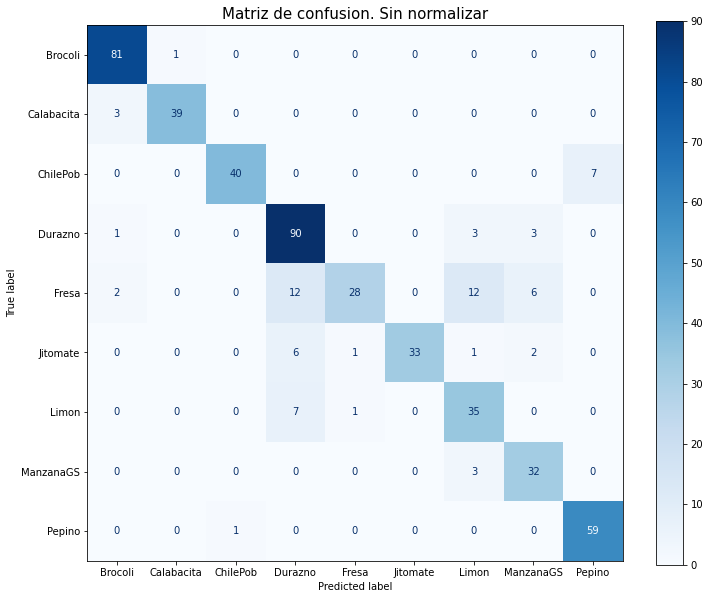

In [44]:
### Mostramos la matriz de confunsión
plt.rcParams['figure.figsize'] = (12, 10)
disp1 = metrics.plot_confusion_matrix(mlp, info2, y_test, cmap=plt.cm.Blues)
disp1.ax_.set_title('Matriz de confusion. Sin normalizar',{'fontsize':15})
plt.show()

Ya que la tarea menciona que generemos un archivo.csv con los valores y la clase a continuación se va a realizar dicha tarea, no se realizo antes ya que se hubiera tenido que juntar y posteriormente separar para ingresarlos a la función MLPClassifier y como los datos ya se encontraban separados se opto por seguir con los mismos separados.

In [45]:
info1['clase'] = y_train
info2['clase'] = y_test

Volvemos a guardar cada uno de los dataframe en su respectivo archivo. 

In [48]:
info1.to_csv('data_train.csv', index=False)
info2.to_csv('data_test.csv', index=False)

#### Comentarios:

La función $Kobe$ nos proporciona un vector con las caracteristicas de tipo color, forma y textura de cada una de las imagenes, se intento buscar ciertos valores más distintivos de cada uno de los grupos de frutas, esto con el fin de ayudar mejor al modelo de red neuronal que nos piden. Al encontrar dichos valores los proporcionamos para que el modelo nos brindara los resultados en ambos conjuntos(entrenamiento y prueba), los resultados del modelo fueron algunas metricas incluyendo el valor de accuracy. Para el conjunto de entrenamiento nos devolvio un valor de accuracy de 0.96 el cual fue bastante bueno y el valor correspondiente al conjunto de prueba fue de 0.86. Ambos resultados fueron buenos para el conjunto de caracteristicas que tomamos en cuenta, incluso con los parámetros que propocionamos ya que en un principio no arrojaba buenos valores y pedia ir cambiandolos, hasta el número de iteraciones nos ayudo a mejorar el resultado.

Al observar la matriz de confunción encontramos que muchas de las frutas y verduras, fueron en su gran mayoria bien clasificadas, ejemplo de ello fueron el brocoli, durazno y pepino. Los resultados se los podemos atribuir quizá a la forma que tienen alguno de ellos(pepino) que no lo encontramos en otro grupo de fruta o verdura, incluso hasta los colores que tiene cada grupo le diera los valores indicados para no equivocarse tanto en la clasificación. 

En otros casos como la fresa, encontramos muchas de sus imagenes mal clasificadas y nos fue algo curioso el resultado ya que esperariamos que las confundiera con el tomate pero no fue así, confundio las imagenes con grupos correspondientes al durazno, limón, manzanaGS y brocoli. De primer momento uno pensaria que no hay cierta relación entre una fresa y los demás grupos pero para nuestro caso puede haber una buena expliación, por ejemplo, algunas imagenes del conjunto de brocoli muestran la parte superior, la parte donde se encuentra el florete, ahí encontramos una textura parecida a la que tiene la fresa en su superficie, puede que este parecido nos diera mal la clasificación, también  hay mencionar que nuestro vector de caracteristicas en su gran mayoria esta compuesto por valores correspondientes a los distintos filtros de gabor, en otras palabras la caracteristica de textura tiene más peso ya que contempla más valores en el vector solicitado. Lo mismo podemos decir para el limón, ya que al observar las imagenes de entrenamiento encontramos que hay algunas que presentan más de cerca la textura del limón y este puede ser el factor que dio como resultado malas clasificaciones. 

De forma general podemos decir que hubo muchas imagenes bien clasificadas y otras no tanto pero hay muchas opciones que se pueden tomar en cuenta incluso tecnicas de la extracción de caracteristicas, por ejempo, hacer una función que obtenga el mismo número de valores para el color, forma y textura, para evitar lo que nos sucedio con las fresas o posiblemente nos de resultados nuevamente extraño como ahora si confundir las fresas con los tomates. Los documentos generados con la función y los que pide el ejercicio se anexaran junto con este Jupyter Notebook. 

In [ ]:
#fin